# Кластеризация. Метод K-Means. Домашнее задание

## Задача

Пусть имеется набор данных `Mall_Customers.csv` о покупателях супермаркета:

* CustomerID — идентификатор покупателя;
* Genre — пол;
* Age — возраст;
* Annual Income (k$) — годовой доход покупателя в тыс. долл.;
* Spending Score (1–100) — рейтинг трат покупателя.

Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы.

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

### Задание 1

Загрузите датасет и выполните разведочный анализ данных. 

Cделайте выводы о найденных закономерностях, особенностях и других обнаруженных свойствах данных.

In [2]:
# Загрузка данных из файла
Mall_df = pd.read_csv("Mall_Customers_(1).csv")

In [3]:
Mall_df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Описание данных

Дан файл Mall_Customers.csv, содержащий следующие данные по покупателям сети супермаркетов:
- CustomerID — идентификатор покупателя.
- Genre – пол покупателя.
- Age – возраст покупателя.
- Annual Income (k\$) – годовой доход покупателя, тысяч $.
- Spending Score (1–100) – рейтинг покупателя

In [4]:
Mall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Из общей информации df следует:
1. DataFrame содержит 200 записей (от индекса 0 до 199)
2. Всего 5 колонок
3. Нулевые значения отсуствуют
4. Пропущенные значения отсуствуют
5. Колонки CustomerID, Age, Annual Income (k$), Spending Score (1-100) в формате int64 и Genre в формате object

In [5]:
# Статистический анализ числовых переменных
Mall_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


На основе представленных статистических данных неприрывных признаков можно сделать следующие выводы:

Age (Возвраст покупателя):

- Средний возвраст на уровне 36.00
- Миниманая 18.00
- Максимальная 70.00
- Медиана равна 39.85
- Отклонение состовляет 13.96

Annual Income (Годовой доход покупателя):

- Средний доход на уровне 61.50
- Миниманая 15.00
- Максимальная 137.00
- Медиана равна 60.56
- Отклонение состовляет 26.26

Spending Score (Рейтинг покупателя):

- Средний рейтинг на уровне 50.00
- Миниманая 99.00
- Максимальная 1.00
- Медиана равна 50.20
- Отклонение состовляет 25.82

CustomerID - уникальный номер клиента не учитываем.

Данные нормализованы, не имеют выбросов.

In [6]:
# Статистический анализ объектных переменных
Mall_df.describe(include='object').T

,count,unique,top,freq
Genre,200,2,Female,112



Genre (Пол покупателя):

В данных присутствуют записи о поле у 200 пользователей.
Имеются две уникальные записи о поле покупателя.
Наиболее часто встречающийся запись - Female, с частотой 112 раз.

In [7]:
# Проверка на дубликаты
duplicate_df = Mall_df[Mall_df.duplicated()]
print("number of duplicate rows: ", duplicate_df.shape)

number of duplicate rows:  (0, 5)


Дубликатов не обнаружено.

In [8]:
# Проверка на NaN значения
Mall_df.isnull().any().any()

False

In [9]:
# Проверка на нулевые значения
Mall_df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

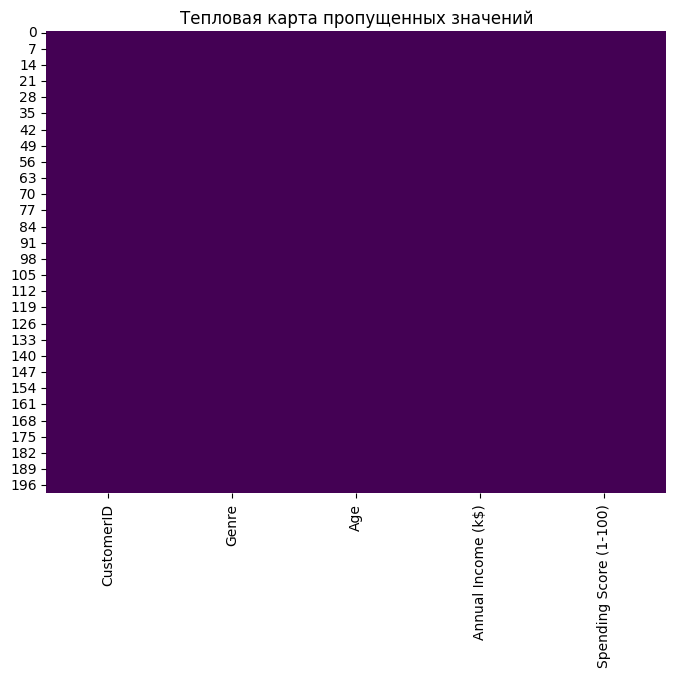

In [10]:
# Визуализация пропущенных значений (тепловая карта)
plt.figure(figsize=(8, 6))
sns.heatmap(Mall_df.isnull(), cbar=False, cmap='viridis')
plt.title('Тепловая карта пропущенных значений')
plt.show()

Пропусков/NaN значений не обнаружено. 

##### Исследуем данные по колонкам:

In [11]:
# Удаляем столбец CustomerID 
Mall_df = Mall_df.drop('CustomerID', axis=1)

Данный столбец CustomerID содержит индивидуальный номер клиента в порядке нумерации от 0 до 199 и не имеет ценности для построения модели или для анализа данных.

In [12]:
# Уникальные значения и их количество Genre
Mall_df['Genre'].value_counts()

Genre
Female    112
Male       88
Name: count, dtype: int64

In [13]:
# Уникальные значения и их количество Age
Mall_df['Age'].value_counts()

Age
32    11
35     9
19     8
31     8
30     7
49     7
40     6
38     6
47     6
27     6
36     6
23     6
34     5
20     5
29     5
50     5
48     5
21     5
24     4
18     4
28     4
67     4
59     4
54     4
43     3
60     3
45     3
39     3
33     3
37     3
22     3
25     3
46     3
68     3
52     2
44     2
66     2
57     2
26     2
53     2
42     2
63     2
70     2
51     2
58     2
65     2
41     2
55     1
69     1
64     1
56     1
Name: count, dtype: int64

In [14]:
# Уникальные значения и их количество Annual Income (k$)
Mall_df['Annual Income (k$)'].value_counts()

Annual Income (k$)
54     12
78     12
48      6
71      6
63      6
       ..
58      2
59      2
16      2
64      2
137     2
Name: count, Length: 64, dtype: int64

In [15]:
# Уникальные значения и их количество Spending Score (1-100)
Mall_df['Spending Score (1-100)'].value_counts()

Spending Score (1-100)
42    8
55    7
46    6
73    6
35    5
     ..
31    1
44    1
53    1
65    1
18    1
Name: count, Length: 84, dtype: int64

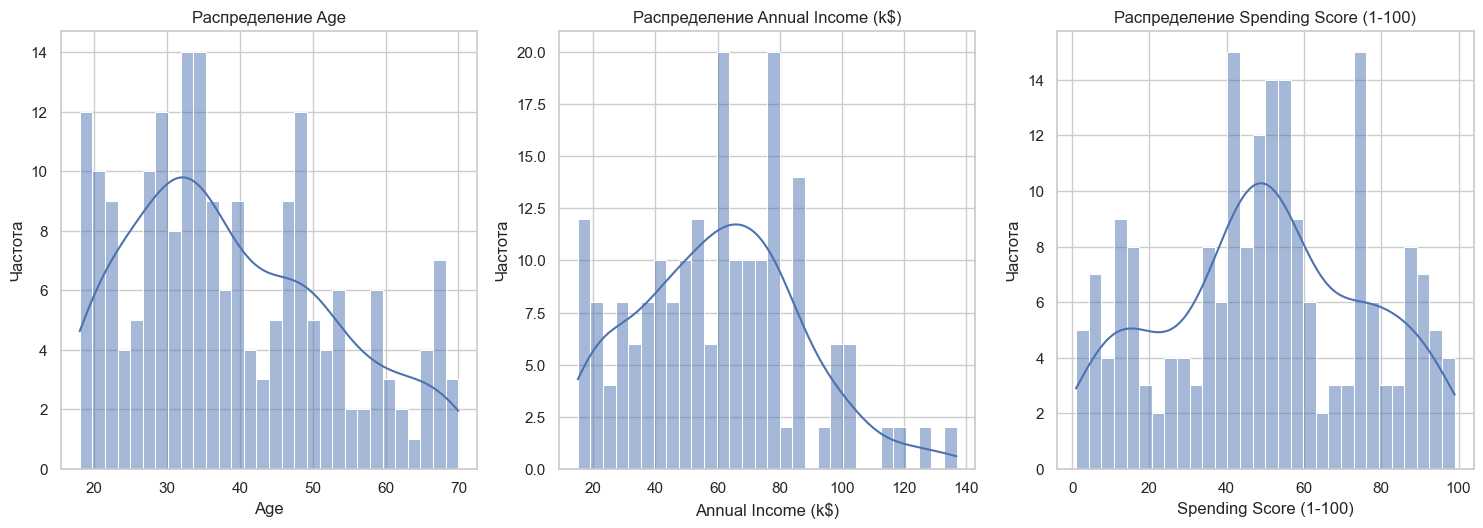

In [16]:
# Установка стиля графиков
sns.set(style="whitegrid")

# Визуализация распределения нескольких выбранных числовых переменных
selected_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

plt.figure(figsize=(15, 10))

for i, column in enumerate(selected_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(Mall_df[column], kde=True, bins=30)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Age - На данном графике видно, что приемущественая часть клиентов идёт от 18 до 35 лет, причём прик приходятся на возраст от 33 до 35 лет далее он идёт по снисходящей в право с некоторым всплеском в 48 лет. Данный графкие говорит о том, что клиенты начинают формироваться в 18 лет, основнная масса клиентов находится в возрасте от 33 до 35 лет и в возрасте 47 до 48 лет они также демострируют хороную покупательскую способность.

Annual Income (k$) - плавно повышается до пика и содержит в себе правий хвост, что говорит, о том, что средняя зарплата людей с хорошей покупательской способностью находится в диапазоне от 50 до 75 а затем наблюдается хвост в который содержит небольшое количество состоятельных граждан.

Spending Score (1-100) - имеет три пика которые говорят о сложной системе траты бонусов клиентами, но их можно поделить на три категории, первую тех кто не копит много и старается как можно скорее потратить балы об этом свидетельствует первый пик в районе от 10 до 19 бонусов. Вторая категория это основная масса клиентов которая, тратит бонусы после некоторого количества покупок начиная от 40 до 60 балов и третьей катерии которая также малочислена как и первая но при этом это люди которые либо забывают про балы или копят их для большой разовой траты.

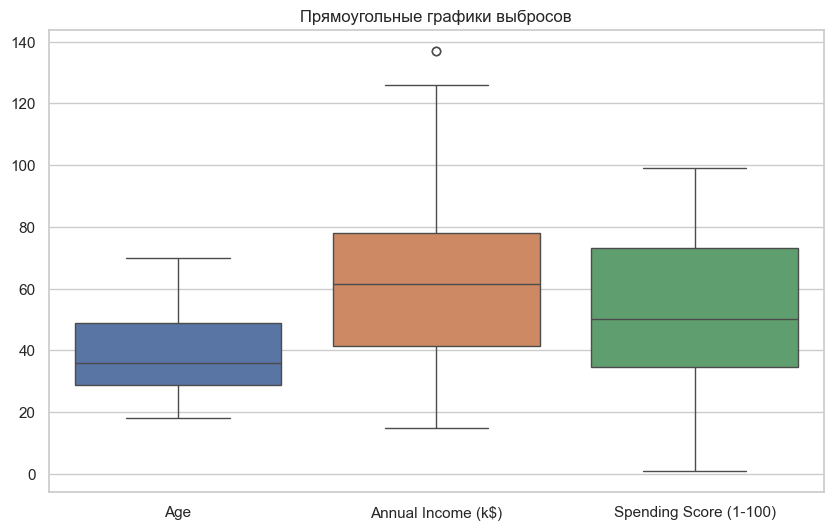

In [17]:
# Прямоугольные графики для визуализации распределений и потенциальных выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(data=Mall_df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.title("Прямоугольные графики выбросов")
plt.show()

Замечен небольшой выброс в колонке Annual Income (k$)

C:\Users\Esdesu\AppData\Local\Temp\ipykernel_7652\3060221776.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Genre', data=Mall_df, palette='Set2')


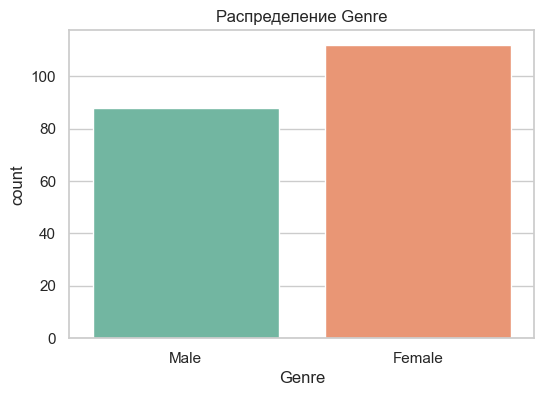

In [18]:
# Проверка баланса категириональных признаков
plt.figure(figsize=(6, 4))
sns.countplot(x='Genre', data=Mall_df, palette='Set2')
plt.title("Распределение Genre")
plt.show()

Сильный дисбаланс между классами отсуствует

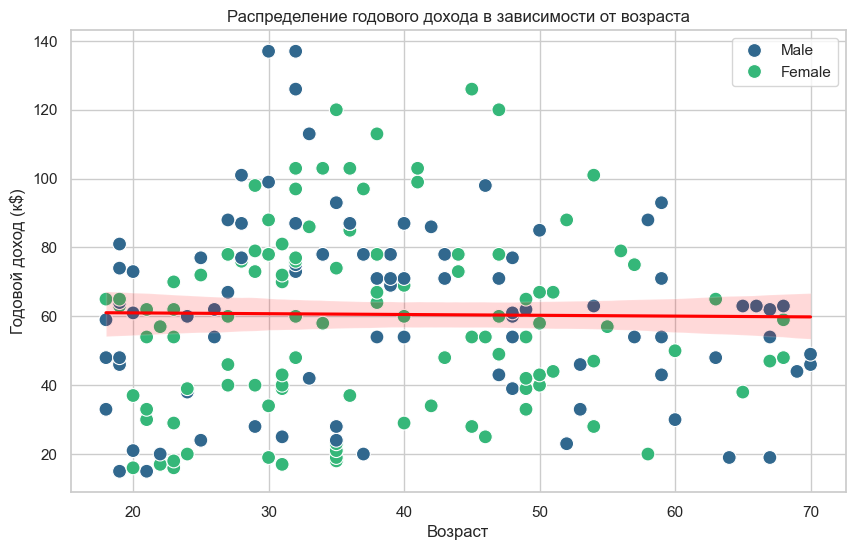

In [19]:
# Построение графика распределения дохода в зависимости от возраста
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Mall_df, x='Age', y='Annual Income (k$)', hue='Genre', palette='viridis', s=100)
sns.regplot(data=Mall_df, x='Age', y='Annual Income (k$)', scatter=False, color='red', line_kws={"label": "Линия регрессии"})
plt.title('Распределение годового дохода в зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Годовой доход (к$)')
plt.legend()
plt.grid(True)
plt.show()

Здесь мы видим как годовой доход распределяется в зависимости от возраста, а также линию регрессии, которая помогает понять общий тренд.

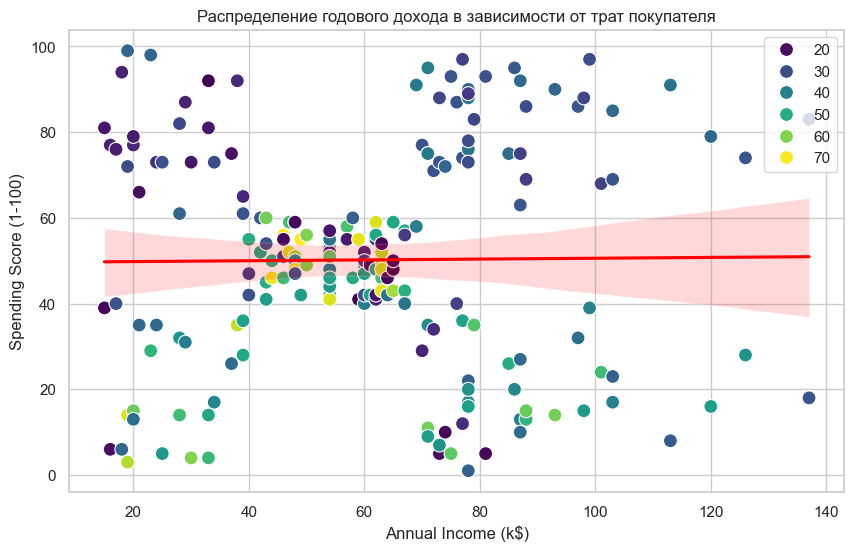

In [20]:
# Построение графика распределения дохода в зависимости от трат покупателя
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Mall_df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Age', palette='viridis', s=100)
sns.regplot(data=Mall_df, x='Annual Income (k$)', y='Spending Score (1-100)', scatter=False, color='red', line_kws={"label": "Линия регрессии"})
plt.title('Распределение годового дохода в зависимости от трат покупателя')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid(True)
plt.show()

График показывает, что существует положительная корреляция между тратами покупателя и годовым доходом, покупатели с более высоким доходом, тратят больше денег так же можно проследить возрастные траты где видно, что люди в среднем возрасте тратят больше.

### Задание 2

Метод k-средних требует явно задать количество кластеров, на которые будут разбиваться данные. Поскольку данных может быть настолько много, что построение одной модели будет занимать несколько часов, важно примерно оценить количество кластеров до запуска обучения модели.

На основе результатов разведочного анализа данных предположите, какое количество кластеров будет оптимальным, и аргументируйте предположение.

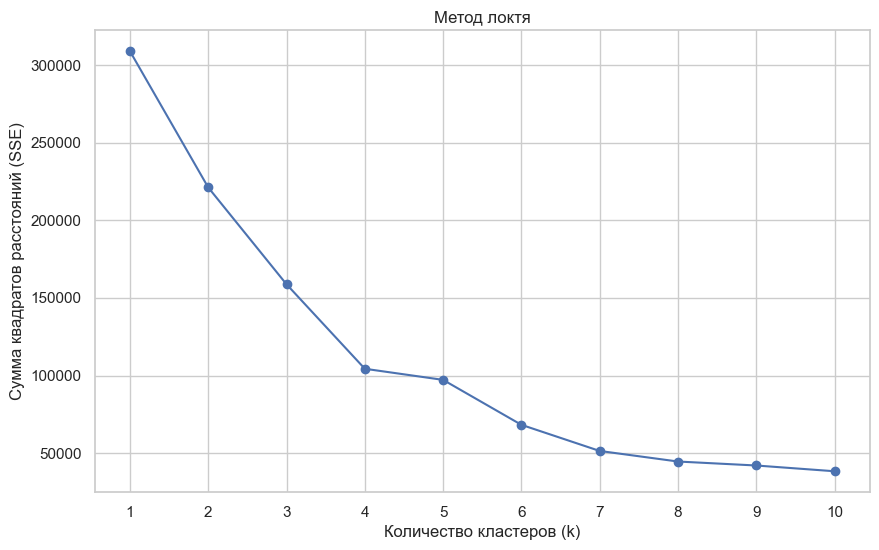

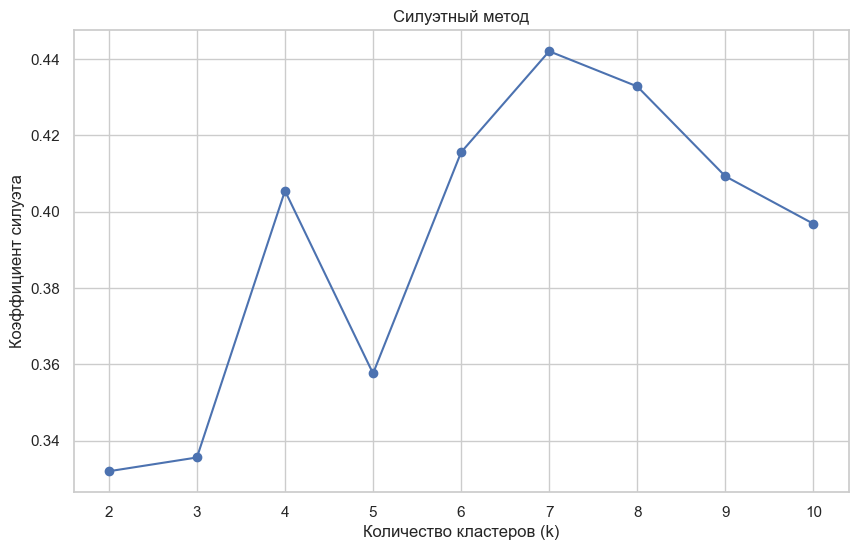

In [21]:
# Выбор переменных для кластеризации: Возраст, Годовой доход и рейтинг трат
X = Mall_df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Метод локтя для выбора оптимального количества кластеров
sse = []
k_values = range(1, 11)  # Проверяем от 1 до 10 кластеров

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # Сумма квадратов расстояний

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов расстояний (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Силуэтный метод
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Силуэтный метод')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

На основе данных полученых при анализе данных и метода локтя локтя 4 ил  5 кластеров, однако силуэтный метод даёт дополнительную информацию на основание которой у нас будет 4 или 7 кластер. Так же важно заметить, что проводилось без нормализации и уменьшения базы данных.

### Задание 3

Преобразуйте категориальный признак Genre в численный.

In [22]:
# Преобразование категориальных данных в численый
Mall_df['Genre'] = Mall_df['Genre'].map({'Male': 0, 'Female': 1})

### Задание 4

Постройте модель кластеризации с помощью метода k-средних. Определите оптимальное количество кластеров с помощью метода локтя.

Значение ниже 0.5 обычно указывает на то, что кластеры не очень четко отделены друг от друга. Это может означать, что нужно сделать изменения параметров кластеризации: количества кластеров, выбора другого алгоритма кластеризации или предварительной обработки данных нормализации или уменьшения размерности.

Перед продолжением нужно определиться с выбором признаков для кластеризации.

Age и Annual Income (k$) - это комбинация может помочь разделить покупателей на группы с разными возрастными и финансовыми характеристиками.

Age и Spending Score (1–100) - это комбинация может помочь разделить покупателей на группы с разными возрастными и покупательскими характеристиками.

Annual Income (k$) и Spending Score (1–100) - это комбинация может помочь разделить покупателей на группы с разными финансовыми и покупательскими характеристиками.

Все три признака - Age, Annual Income (k$) и Spending Score (1–100) - могут быть использованы вместе для получения более детальной картины покупательского поведения.

Genre - мы не будем использовать поскольку он является мало информативным чем другие признаки, поскольку пол не всегда является основным фактором.

In [23]:
# Выбор всех переменных для кластеризации
X = Mall_df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Определение оптимального количества кластеров
optimal_k_x_1 = 7  # Оптимальное количество кластеров, определенное ранее

# Построение финальной модели KMeans с оптимальным количеством кластеров
kmeans_more_clusters = KMeans(n_clusters=optimal_k_x_1, random_state=42)
Mall_df['Cluster'] = kmeans_more_clusters.fit_predict(X)

# Оценка качества кластеризации
silhouette_kmeans_more = silhouette_score(X, Mall_df['Cluster'])
print(f'Silhouette Score для {optimal_k_x_1} кластеров: {silhouette_kmeans_more}')

Silhouette Score для 7 кластеров: 0.4420336177238127


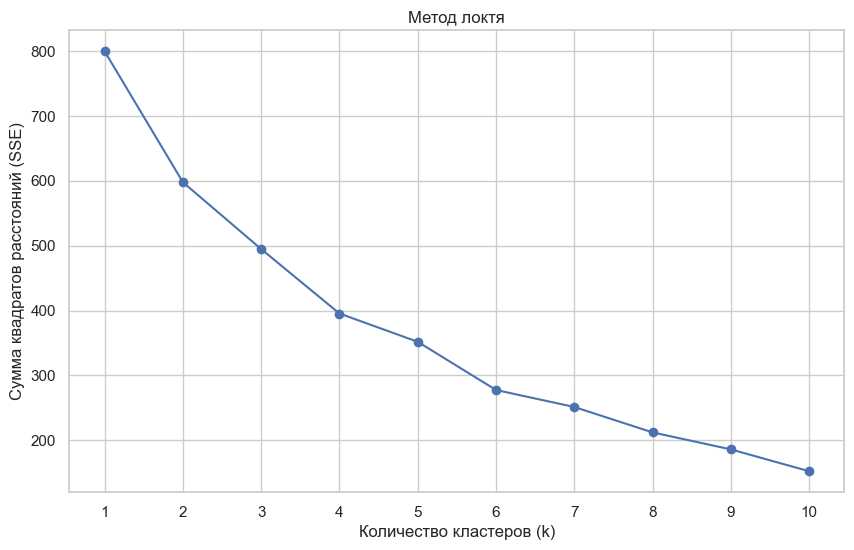

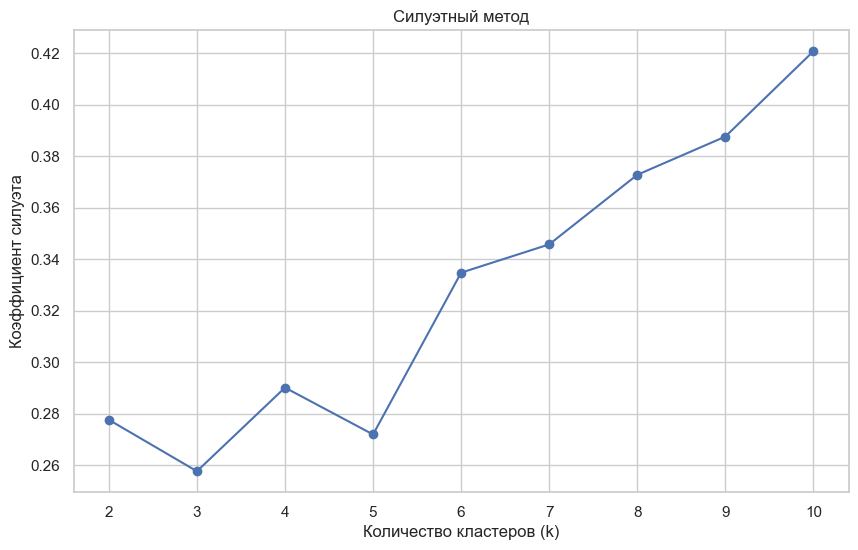

In [24]:
# Выбор всех переменных для кластеризации
X_2 = Mall_df[['Age', 'Genre', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Стандартизация данных для улучшения работы модели
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_2)

# Метод локтя для выбора оптимального количества кластеров
sse = []
k_values = range(1, 11)  # Проверяем от 1 до 10 кластеров

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # Сумма квадратов расстояний

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов расстояний (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Силуэтный метод
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Силуэтный метод')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

In [25]:
# Выбор всех переменных для кластеризации
X_2 = Mall_df[['Age', 'Genre', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Определение оптимального количества кластеров
optimal_k_x_2 = 10  # Оптимальное количество кластеров, определенное ранее

# Стандартизация данных для улучшения работы модели
scaler = StandardScaler()
X_scaled_2 = scaler.fit_transform(X_2)

# Построение финальной модели KMeans с оптимальным количеством кластеров
kmeans_more_clusters_2 = KMeans(n_clusters=optimal_k_x_2, random_state=42)
labels_kmeans_more_2 = kmeans_more_clusters_2.fit_predict(X_scaled_2)

# Оценка качества кластеризации
silhouette_kmeans_more_2 = silhouette_score(X_scaled_2, labels_kmeans_more_2)
print(f'Silhouette Score для {optimal_k_x_2} кластеров: {silhouette_kmeans_more_2}')

Silhouette Score для 10 кластеров: 0.42076374869477745


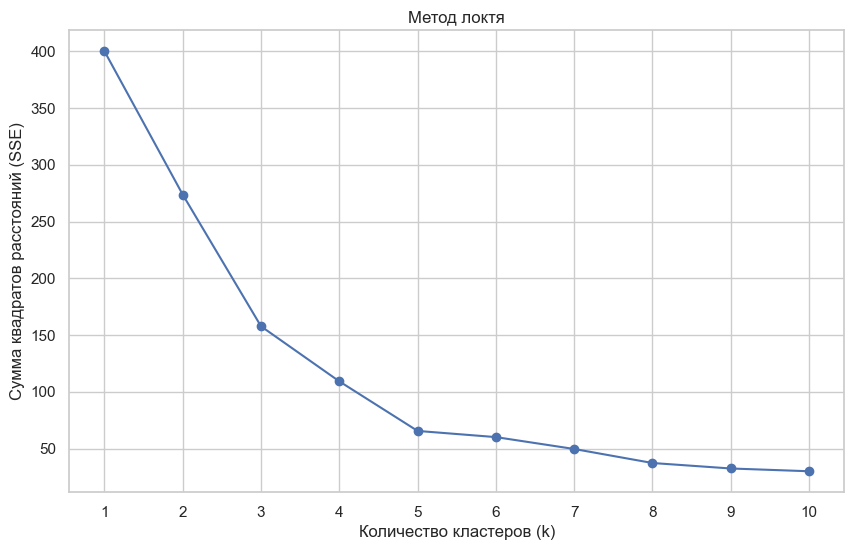

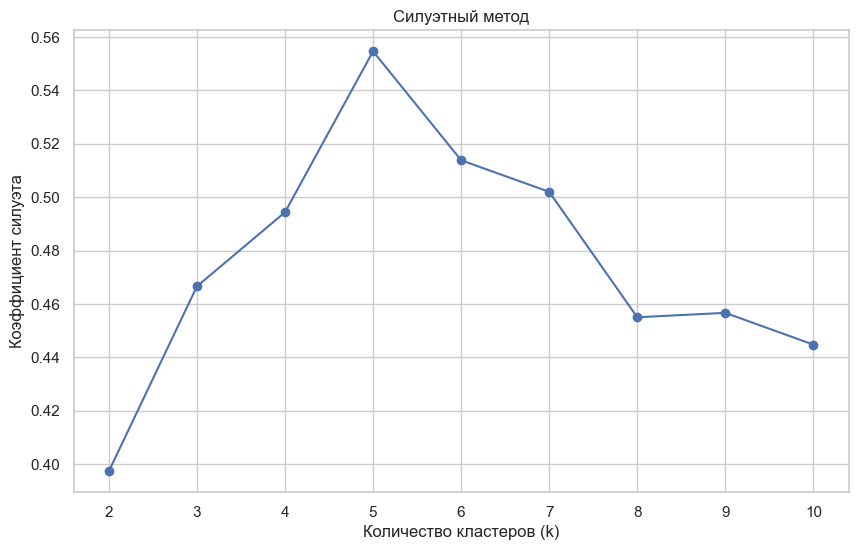

In [26]:
# Выбор переменных для кластеризации: Годовой доход и рейтинг трат
X_3 = Mall_df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Стандартизация данных для улучшения работы модели
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_3)

# Метод локтя для выбора оптимального количества кластеров
sse = []
k_values = range(1, 11)  # Проверяем от 1 до 10 кластеров

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # Сумма квадратов расстояний

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов расстояний (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Силуэтный метод
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Силуэтный метод')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

In [27]:
# Выбор переменных для кластеризации: Годовой доход и рейтинг трат
X_3 = Mall_df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Определение оптимального количества кластеров
optimal_k_x_3 = 5  # Оптимальное количество кластеров, определенное ранее

# Стандартизация данных для улучшения работы модели
scaler = StandardScaler()
X_scaled_3 = scaler.fit_transform(X_3)

# Построение финальной модели KMeans с оптимальным количеством кластеров
kmeans_more_clusters_3 = KMeans(n_clusters=optimal_k_x_3, random_state=42)
labels_kmeans_more_3 = kmeans_more_clusters_3.fit_predict(X_scaled_3)

# Оценка качества кластеризации
silhouette_kmeans_more_3 = silhouette_score(X_scaled_3, labels_kmeans_more_3)
print(f'Silhouette Score для {optimal_k_x_3} кластеров: {silhouette_kmeans_more_3}')

Silhouette Score для 5 кластеров: 0.5546571631111091


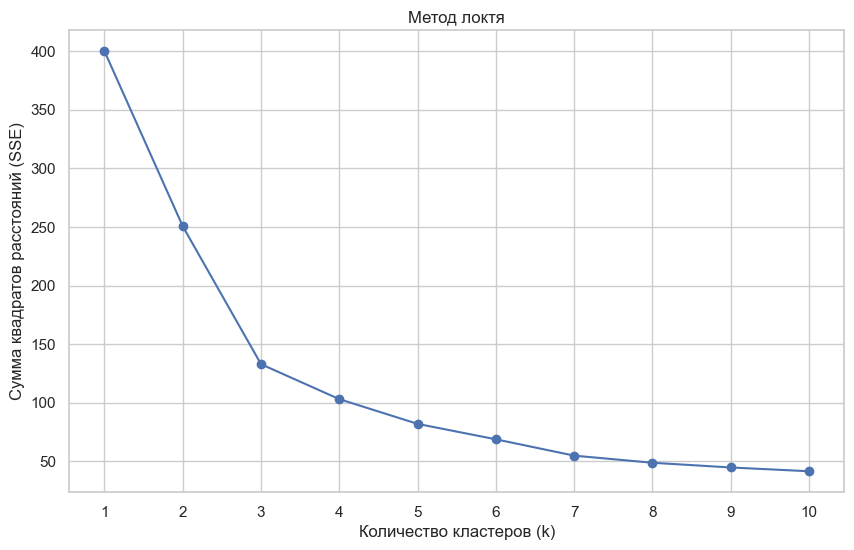

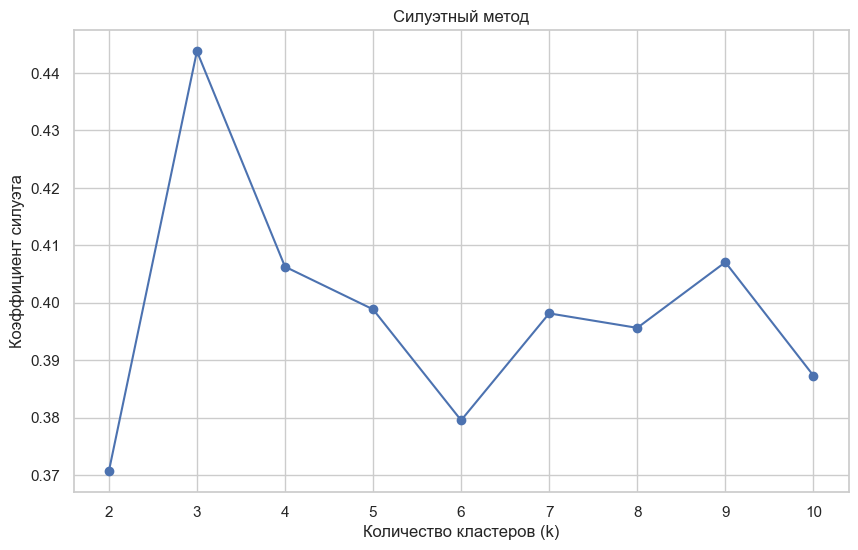

In [28]:
# Выбор переменных для кластеризации: Возраст и Годовой доход
X_4 = Mall_df[['Age', 'Annual Income (k$)']]

# Стандартизация данных для улучшения работы модели
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_4)

# Метод локтя для выбора оптимального количества кластеров
sse = []
k_values = range(1, 11)  # Проверяем от 1 до 10 кластеров

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # Сумма квадратов расстояний

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов расстояний (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Силуэтный метод
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Силуэтный метод')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

In [29]:
# Выбор переменных для кластеризации: Возраст и Годовой доход
X_4 = Mall_df[['Age', 'Annual Income (k$)']]

# Определение оптимального количества кластеров
optimal_k_x_4 = 3  # Оптимальное количество кластеров, определенное ранее

# Стандартизация данных для улучшения работы модели
scaler = StandardScaler()
X_scaled_4 = scaler.fit_transform(X_4)

# Построение финальной модели KMeans с оптимальным количеством кластеров
kmeans_more_clusters_4 = KMeans(n_clusters=optimal_k_x_4, random_state=42)
labels_kmeans_more_4 = kmeans_more_clusters_4.fit_predict(X_scaled_4)

# Оценка качества кластеризации
silhouette_kmeans_more_4 = silhouette_score(X_scaled_4, labels_kmeans_more_4)
print(f'Silhouette Score для {optimal_k_x_4} кластеров: {silhouette_kmeans_more_4}')

Silhouette Score для 3 кластеров: 0.4437863926928188


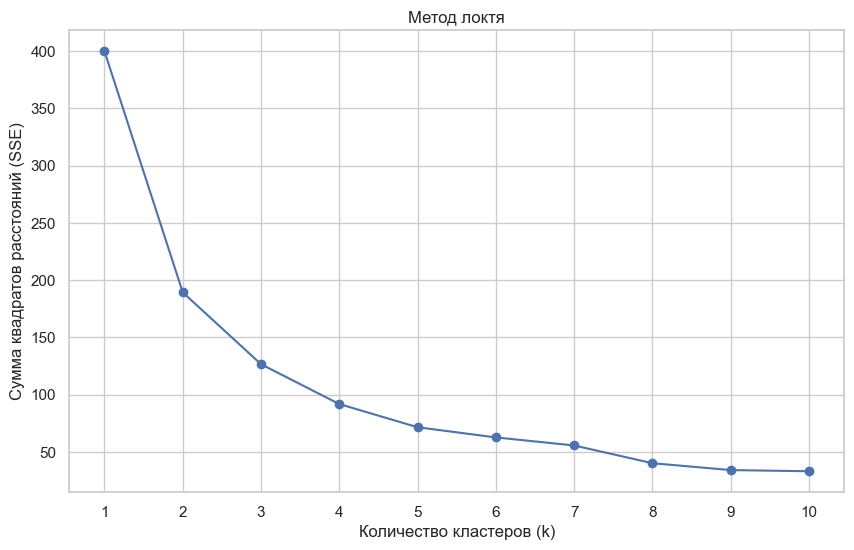

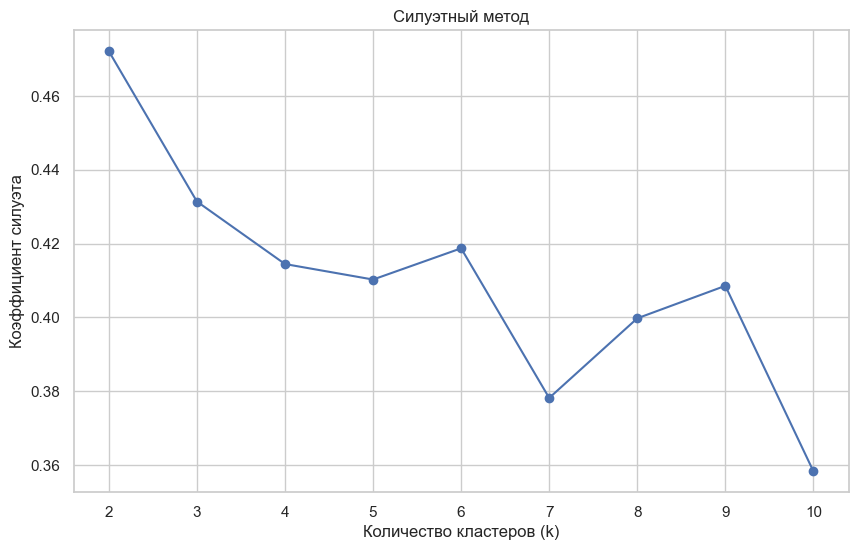

In [30]:
# Выбор переменных для кластеризации: Возраст и рейтинг трат
X_5 = Mall_df[['Age', 'Spending Score (1-100)']]

# Стандартизация данных для улучшения работы модели
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_5)

# Метод локтя для выбора оптимального количества кластеров
sse = []
k_values = range(1, 11)  # Проверяем от 1 до 10 кластеров

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # Сумма квадратов расстояний

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов расстояний (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Силуэтный метод
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Силуэтный метод')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

In [ ]:
# Выбор переменных для кластеризации: Возраст и рейтинг трат
X_5 = Mall_df[['Age', 'Spending Score (1-100)']]

# Определение оптимального количества кластеров
optimal_k_x_5 = 2  # Оптимальное количество кластеров, определенное ранее

# Стандартизация данных для улучшения работы модели
scaler = StandardScaler()
X_scaled_5 = scaler.fit_transform(X_5)

# Построение финальной модели KMeans с оптимальным количеством кластеров
kmeans_more_clusters_5 = KMeans(n_clusters=optimal_k_x_5, random_state=42)
labels_kmeans_more_5 = kmeans_more_clusters_5.fit_predict(X_scaled_5)

# Оценка качества кластеризации
silhouette_kmeans_more_5 = silhouette_score(X_scaled_5, labels_kmeans_more_5)
print(f'Silhouette Score для {optimal_k_x_5} кластеров: {silhouette_kmeans_more_5}')

Silhouette Score для 2 кластеров: 0.4721271643062346


Лучший вариант optimal_k_x_3, изменение количества кластеров с 4 до 5 дало улучшение, а также сужение количества признаков до двух(удаление Age, Genre) дало свише 0.5 при кластирезации KMeans это показывает, что кластеризация имеет умеренное качество.

Лишь один кластер не имеет сферической формы и немножечко смешивается.

### Задание 5

Постройте финальную модель кластеризации с количеством кластеров, опредёленным в предыдущем задании.

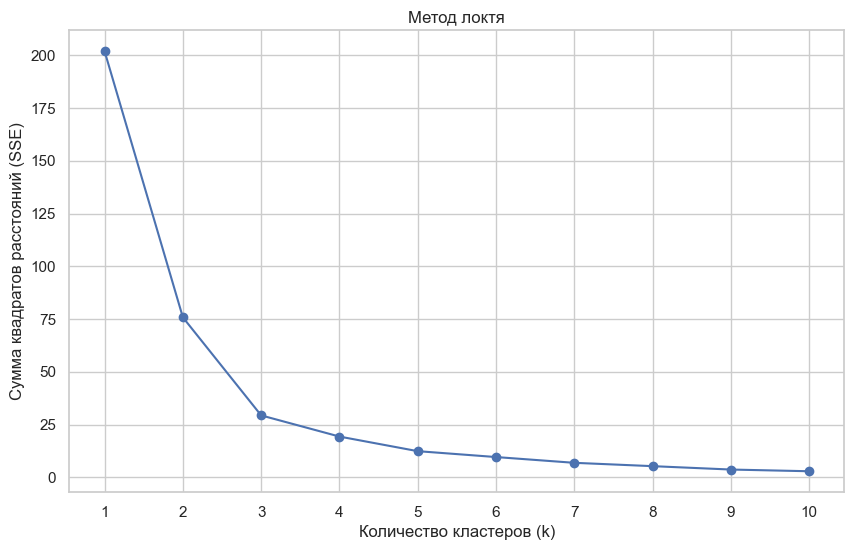

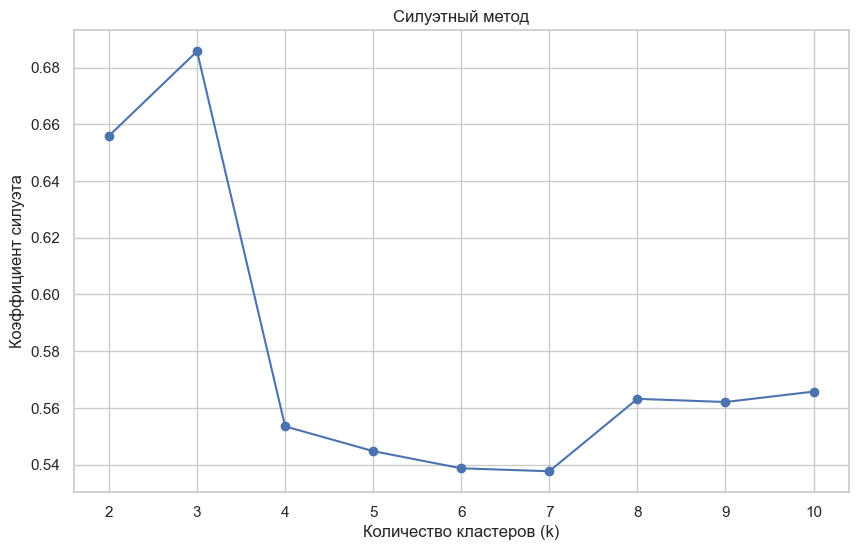

In [32]:
# Выбор переменных для кластеризации
X_F = Mall_df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Стандартизация данных для улучшения работы модели
scaler_F = StandardScaler()
X_scaled_F = scaler_F.fit_transform(X_F)

# Применение PCA для уменьшения размерности данных
pca = PCA(n_components=0.5)  # Выберите необходимое количество компонент
X_pca_F = pca.fit_transform(X_scaled_F)

# Метод локтя для выбора оптимального количества кластеров
sse_F = []
k_values_F = range(1, 11)  # Проверяем от 1 до 10 кластеров

for k in k_values_F:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca_F)
    sse_F.append(kmeans.inertia_)  # Сумма квадратов расстояний

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_values_F, sse_F, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов расстояний (SSE)')
plt.xticks(k_values_F)
plt.grid(True)
plt.show()

# Силуэтный метод
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca_F)
    silhouette_avg = silhouette_score(X_pca_F, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Силуэтный метод')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()


In [33]:
# Создание объекта PCA
pca = PCA()

# Применение PCA к данным
X_pca = pca.fit_transform(X_F)

# Получение процента вариации, объясненной каждым компонентом
explained_variance_ratio = pca.explained_variance_ratio_

# Вывод процента вариации, объясненной каждым компонентом
print(explained_variance_ratio)

[0.50981041 0.49018959]


Silhouette Score для 3 кластеров: 0.6857610634926842


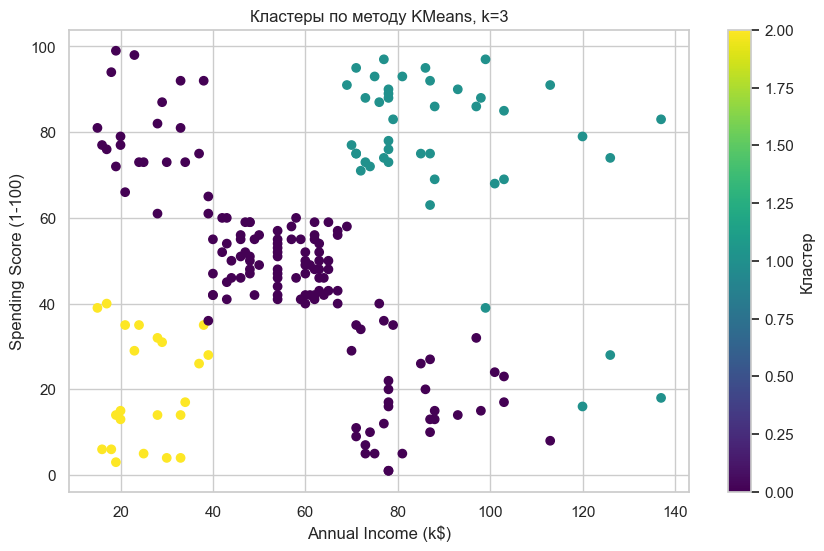

In [34]:
# Определение оптимального количества кластеров
optimal_k_F = 3  # Оптимальное количество кластеров, определенное по графику

# Построение модели KMeans с оптимальным количеством кластеров
kmeans_F = KMeans(n_clusters=optimal_k_F, random_state=42)
Mall_df['Cluster'] = kmeans_F.fit_predict(X_pca_F)

# Оценка качества кластеризации
silhouette_kmeans_more_F = silhouette_score(X_pca_F, Mall_df['Cluster'])
print(f'Silhouette Score для {optimal_k_F} кластеров: {silhouette_kmeans_more_F}')

# Визуализация кластеров по возрасту и доходу
plt.figure(figsize=(10, 6))
plt.scatter(Mall_df['Annual Income (k$)'], Mall_df['Spending Score (1-100)'], c=Mall_df['Cluster'], cmap='viridis', marker='o')
plt.title(f'Кластеры по методу KMeans, k={optimal_k_F}')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.colorbar(label='Кластер')
plt.grid(True)
plt.show()

In [35]:
# Расчет коэффициента силуэта и критерия Калиньского-Харабаза
silhouette_F = silhouette_score(X_pca_F, Mall_df['Cluster'])
chi_F = calinski_harabasz_score(X_pca_F, Mall_df['Cluster'])
print('\nK-Means')
print('_' * 45 + '\n')
print('Силуэт', round(silhouette_F, 3))
print('Variance Ratio Criterion', round(chi_F, 3))


K-Means
_____________________________________________

Силуэт 0.686
Variance Ratio Criterion 578.733


Значение Вариантного Критерия 578,73 указывает на то, что кластеризация является хорошей, значение силуэта 0,686 указывает на то, что кластеризация является тоже хорошей.

# Кластеризация. DBSCAN

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды.
* AFDP — перепад давления на воздушном фильтре.
* GTEP — давление на выходе из газовой турбины.
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины.
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа.
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [36]:
# Загрузка данных из файла
gt_df = pd.read_csv("gt_2015.csv")

In [37]:
gt_df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


### Описание данных

Дан файл gt_2015.csv, содержащий следующие данные о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды.
* AFDP — перепад давления на воздушном фильтре.
* GTEP — давление на выходе из газовой турбины.
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины.
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа.
* NOX — выбросы оксидов азота.

In [38]:
gt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      7384 non-null   float64
 1   AP      7384 non-null   float64
 2   AH      7384 non-null   float64
 3   AFDP    7384 non-null   float64
 4   GTEP    7384 non-null   float64
 5   TIT     7384 non-null   float64
 6   TAT     7384 non-null   float64
 7   TEY     7384 non-null   float64
 8   CDP     7384 non-null   float64
 9   CO      7384 non-null   float64
 10  NOX     7384 non-null   float64
dtypes: float64(11)
memory usage: 634.7 KB


Из общей информации df следует:
1. DataFrame содержит 7384 записей (от индекса 0 до 7384)
2. Всего 11 колонок
3. Нулевые значения отсуствуют
4. Пропущенные значения отсуствуют
5. Все колонки в формате float64

In [39]:
# Статистический анализ числовых переменных
gt_df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,7384.0,17.225259,8.095783,-6.2348,11.073250,17.4565,23.684750,37.1030
AP,7384.0,1014.509110,6.895430,989.4000,1009.675000,1014.0000,1018.300000,1036.6000
AH,7384.0,68.647464,13.541116,24.0850,59.447250,70.9520,79.653750,96.6660
AFDP,7384.0,3.598909,0.610226,2.3688,3.117300,3.5385,4.194825,5.2395
GTEP,7384.0,26.130149,4.473737,17.6980,23.147000,25.3310,30.018250,40.7160
TIT,7384.0,1078.974689,19.762449,1016.0000,1070.500000,1080.3000,1099.900000,1100.4000
TAT,7384.0,546.642484,5.489066,516.0400,544.747500,549.7200,550.030000,550.5900
TEY,7384.0,133.993380,16.179208,100.0200,126.255000,131.6000,147.160000,179.5000
CDP,7384.0,12.097025,1.136601,9.8708,11.465750,11.9330,13.148000,15.1590
CO,7384.0,3.129986,2.234962,0.2128,1.808175,2.5334,3.702550,41.0970


In [40]:
# Проверка на дубликаты
duplicate_df = gt_df[gt_df.duplicated()]
print("number of duplicate rows: ", duplicate_df.shape)

number of duplicate rows:  (0, 11)


Дубликатов не обнаружено.

In [41]:
# Проверка на NaN значения
gt_df.isnull().any().any()

False

In [42]:
# Проверка на нулевые значения
gt_df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

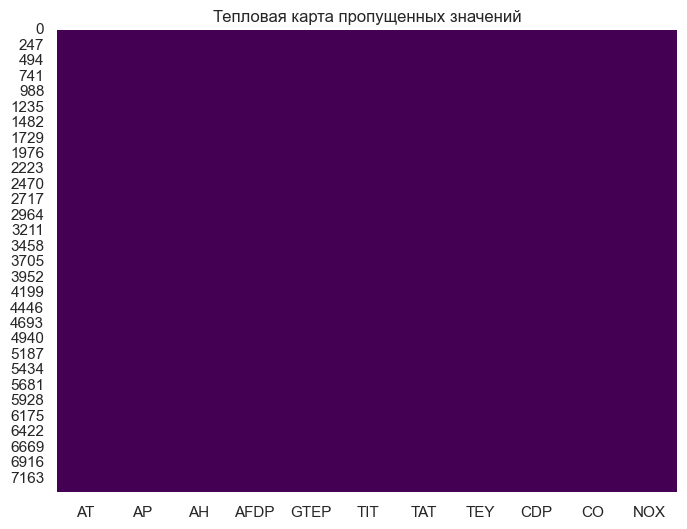

In [43]:
# Визуализация пропущенных значений (тепловая карта)
plt.figure(figsize=(8, 6))
sns.heatmap(gt_df.isnull(), cbar=False, cmap='viridis')
plt.title('Тепловая карта пропущенных значений')
plt.show()

Пропусков/NaN значений не обнаружено. 

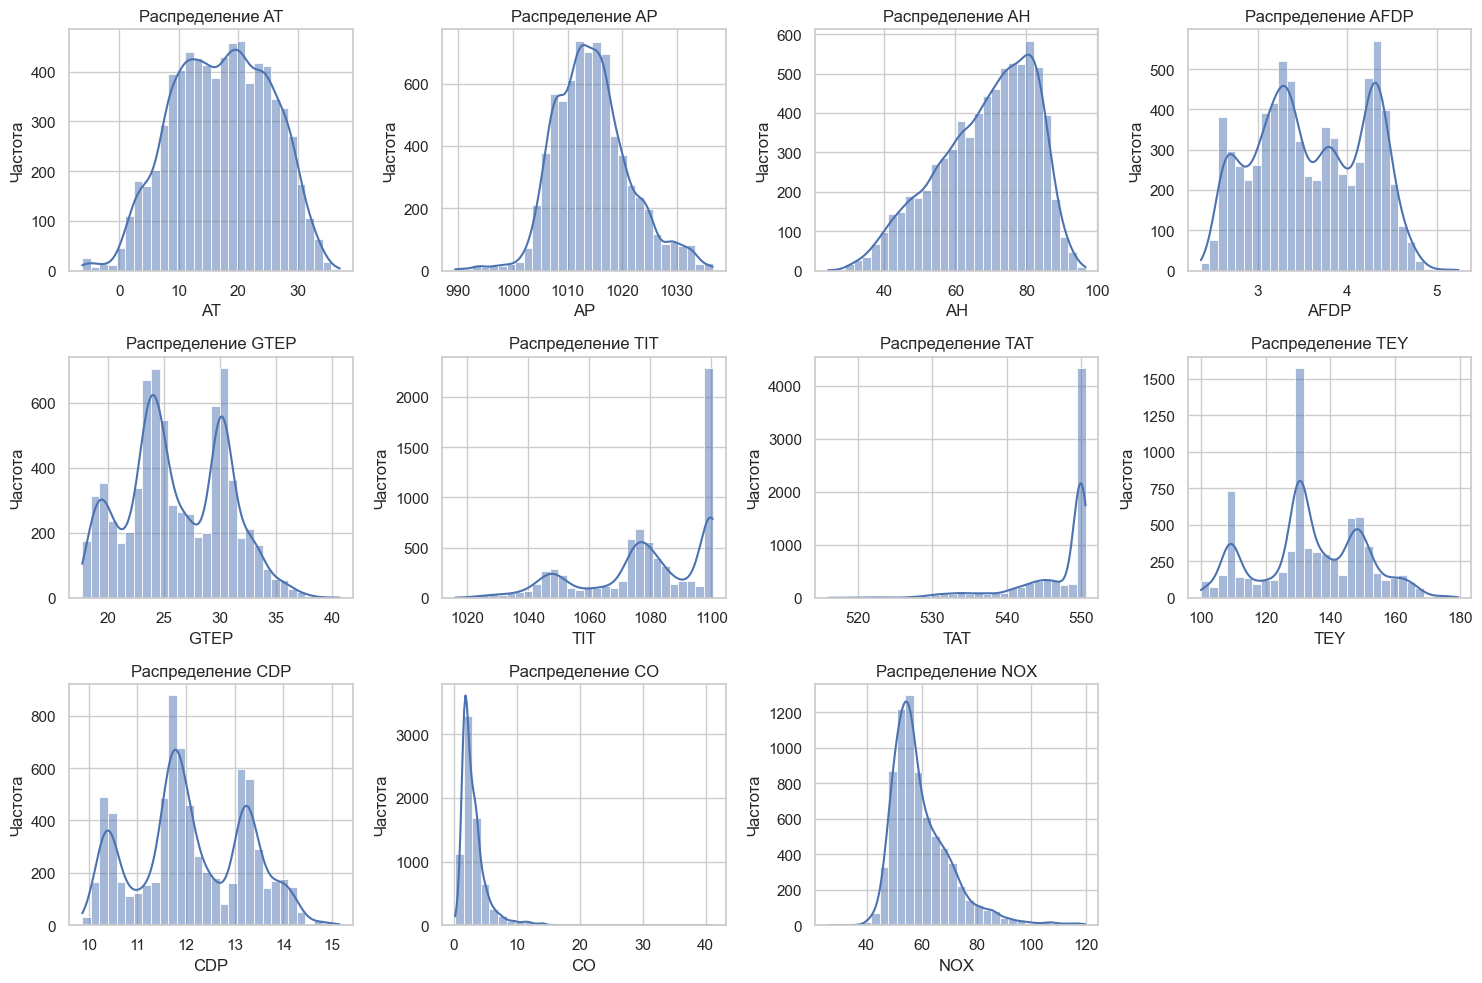

In [44]:
# Установка стиля графиков
sns.set(style="whitegrid")

# Визуализация распределения нескольких выбранных числовых переменных
selected_columns = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',	'NOX']

plt.figure(figsize=(15, 10))

for i, column in enumerate(selected_columns):
    plt.subplot(3, 4, i + 1)
    sns.histplot(gt_df[column], kde=True, bins=30)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

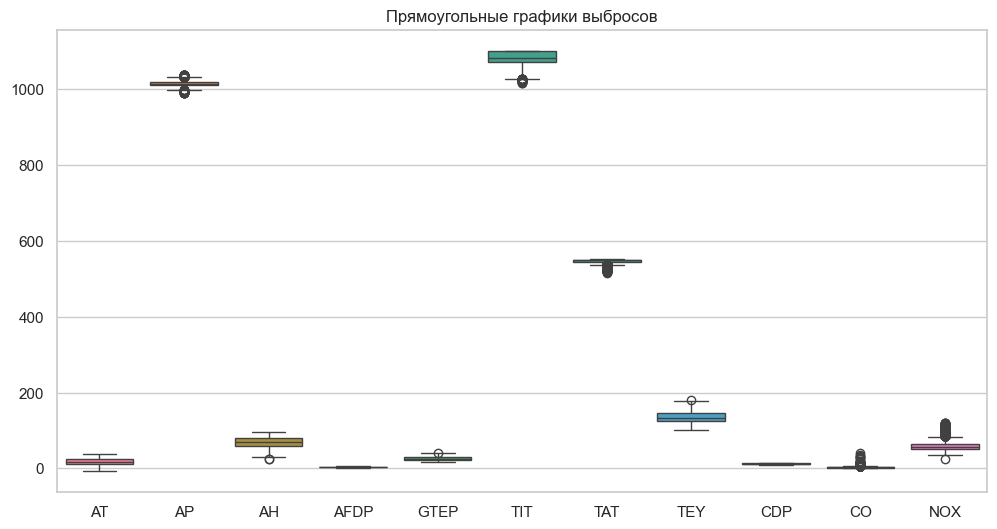

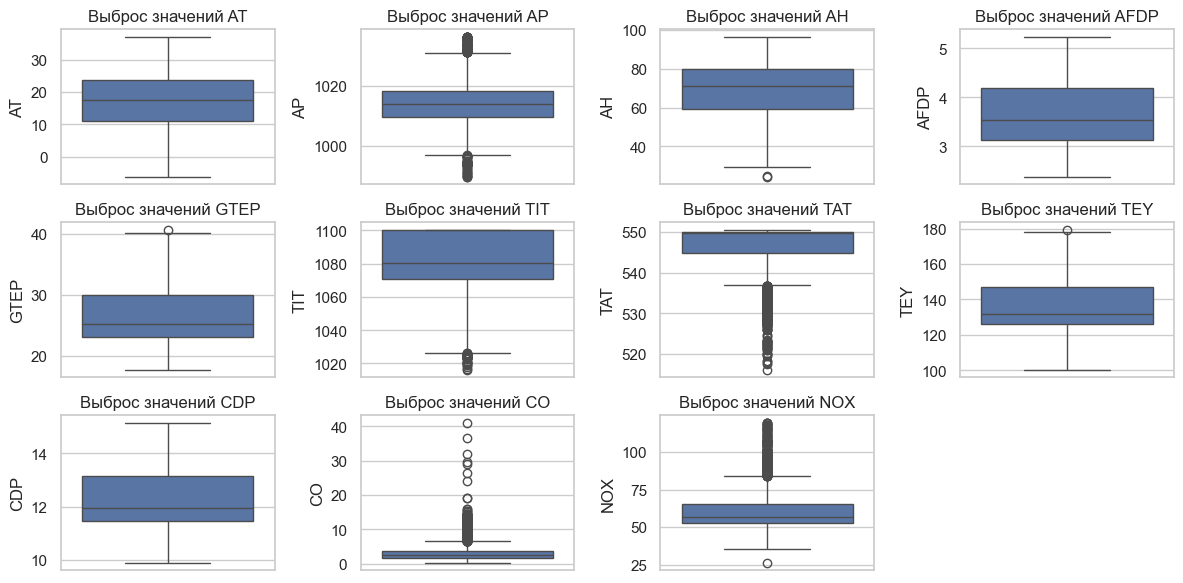

In [45]:
# Прямоугольные графики для визуализации распределений и потенциальных выбросов
# Визуализация распределения нескольких выбранных числовых переменных
selected_columns = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',	'NOX']

plt.figure(figsize=(12, 6))

sns.boxplot(data=gt_df[['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',	'NOX']])
plt.title("Прямоугольные графики выбросов")
plt.show()

plt.figure(figsize=(12, 6))
for i, column in enumerate(selected_columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=column, data=gt_df)
    plt.title(f"Выброс значений {column}")
    plt.ylabel(column)
plt.tight_layout()
plt.show()

In [46]:
# Функция для выявления выбросов по методу Z-нормализации
def detect_outliers_z_score(gt_df, column):
    mean = gt_df[column].mean()
    std = gt_df[column].std()
    z_scores = [(x - mean) / std for x in gt_df[column]]
    return [x for x, z in zip(gt_df[column], z_scores) if abs(z) > 3]

# Функция для выявления выбросов по методу IQR
def detect_outliers_iqr(gt_df, column):
    q1 = gt_df[column].quantile(0.25)
    q3 = gt_df[column].quantile(0.75)
    iqr = q3 - q1
    return [x for x in gt_df[column] if (x < (q1 - 1.5 * iqr)) or (x > (q3 + 1.5 * iqr))]

# Функция замены выбросов на медиану
def replace_outliers(gt_df, column):
    median = gt_df[column].median()
    gt_df[column] = gt_df[column].apply(lambda x: median if ((x - median) / gt_df[column].std() > 3) or ((x < gt_df[column].quantile(0.25) - 1.5 * (gt_df[column].quantile(0.75) - gt_df[column].quantile(0.25))) or (x > gt_df[column].quantile(0.75) + 1.5 * (gt_df[column].quantile(0.75) - gt_df[column].quantile(0.25)))) else x)
    return gt_df

# Функция для нормализации данных в столбце
def normalize_data(gt_df, column):
    scaler = MinMaxScaler()
    gt_df[column] = scaler.fit_transform(gt_df[[column]])
    return gt_df, scaler

# Выявление и замена выбросов в определенных колонках
for column in ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',	'NOX']:
    outliers_z = detect_outliers_z_score(gt_df, column)
    outliers_iqr = detect_outliers_iqr(gt_df, column)
    if outliers_z:
        print(f'Выбросы по методу Z-нормализации в столбце {column}: {outliers_z}')
    if outliers_iqr:
        print(f'Выбросы по методу IQR в столбце {column}: {outliers_iqr}')
    gt_df = replace_outliers(gt_df, column)
    gt_df, scaler = normalize_data(gt_df, column)

Выбросы по методу Z-нормализации в столбце AP: [1035.5, 1035.6, 1035.3, 1035.6, 1035.7, 1035.8, 1036.3, 1036.4, 1036.4, 1036.3, 1035.7, 1035.3, 1035.4, 1035.5, 1035.8, 1036.0, 1036.3, 1036.5, 1036.6, 1036.5, 1036.3, 1036.2, 1035.8, 1035.2, 993.79, 993.35, 993.29, 993.42, 993.8, 993.51, 993.76, 993.51, 993.62, 993.82, 993.42, 992.86, 992.29, 991.8, 991.4, 990.81, 990.17, 989.69, 989.42, 989.4, 989.8, 990.3, 990.64, 991.26, 992.34, 993.45]
Выбросы по методу IQR в столбце AP: [1031.8, 1032.2, 1032.5, 1033.4, 1034.2, 1034.6, 1034.8, 1035.1, 1035.5, 1035.6, 1035.3, 1035.6, 1035.7, 1035.8, 1036.3, 1036.4, 1036.4, 1036.3, 1035.7, 1035.3, 1035.4, 1035.5, 1035.8, 1036.0, 1036.3, 1036.5, 1036.6, 1036.5, 1036.3, 1036.2, 1035.8, 1035.2, 1034.9, 1034.5, 1034.1, 1034.0, 1033.6, 1033.3, 1033.2, 1032.8, 1032.1, 996.45, 996.36, 995.4, 994.32, 993.79, 993.35, 993.29, 993.42, 993.8, 993.51, 994.25, 994.76, 994.33, 994.03, 993.76, 993.51, 993.62, 994.03, 994.34, 994.63, 994.44, 993.91, 993.92, 993.82, 993

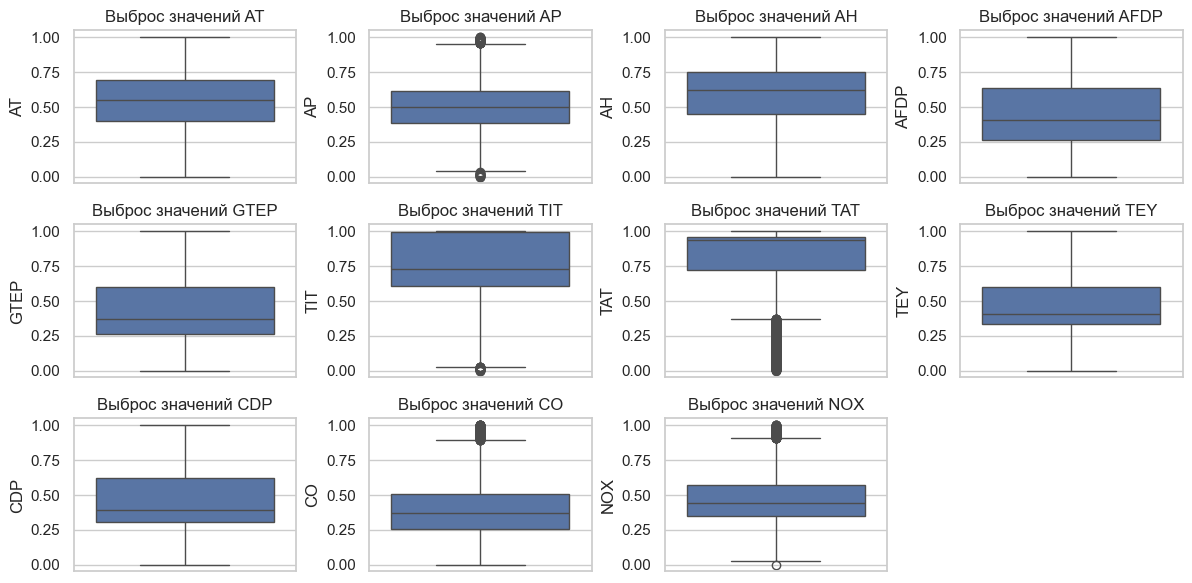

In [47]:
# Прямоугольные графики для визуализации распределений и потенциальных выбросов
# Визуализация распределения нескольких выбранных числовых переменных
selected_columns = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',	'NOX']

plt.figure(figsize=(12, 6))
for i, column in enumerate(selected_columns):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=column, data=gt_df)
    plt.title(f"Выброс значений {column}")
    plt.ylabel(column)
plt.tight_layout()
plt.show()

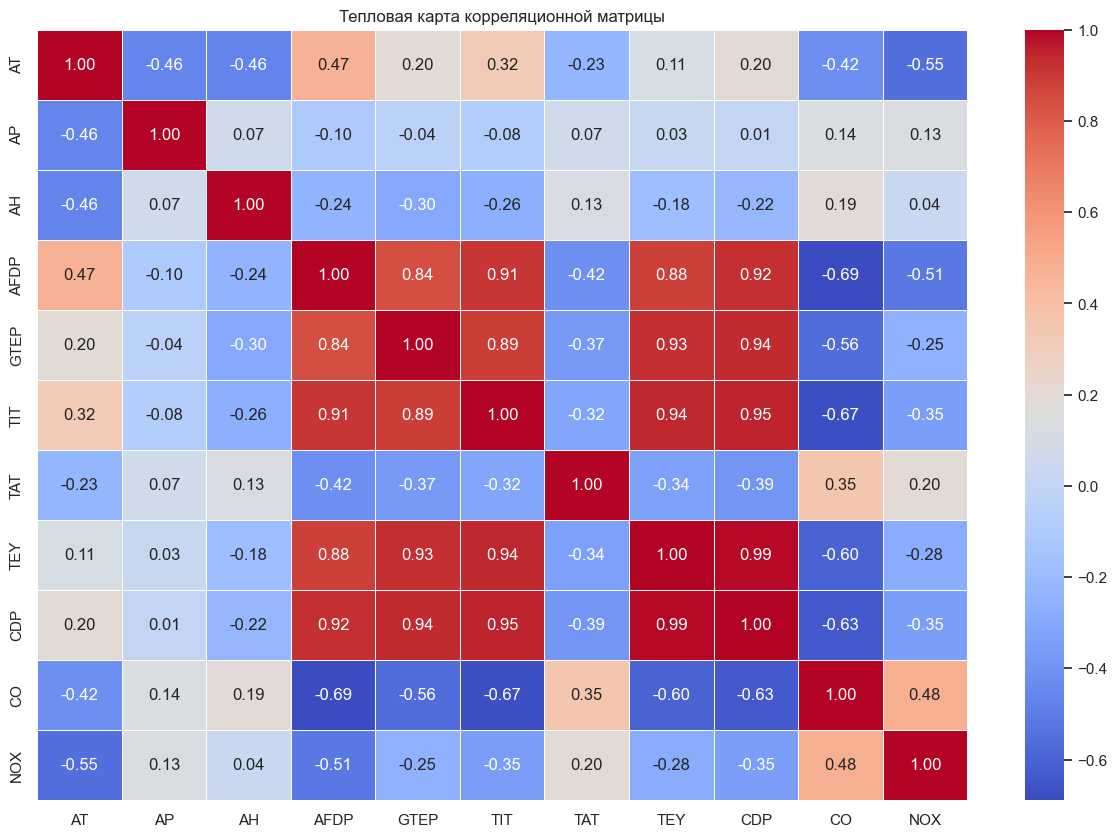

In [48]:
correlation_matrix = gt_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Тепловая карта корреляционной матрицы")
plt.show()

# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

Взяв за основу AT, AFDP, GTEP, TEY, CDP, CO электростанции можно разделить на группы:

1. Высокими значениями электростанции с высокой производительностью.

2. Средними значениями электростанции с средней производительностью.

3. С низкими значениями электростанции с низкой производительностью.

4. С Анамальными параметрами имеют необычную производительность.

Так же можно взять экологическую часть TEY, CO, NOX разделить на три группы загрезнения окружающей среды в зависимости от производительности:

1. Высокими значениями электростанции с высоким содержанием оксидов азота.

2. Средними значениями электростанции с средним содержанием оксидов азота.

3. С низкими значениями электростанции с низким содержанием оксидов азота.

# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.

In [87]:
# Выбор переменных для кластеризации
X_D = gt_df[['AT', 'AFDP', 'GTEP', 'TEY', 'CDP', 'CO']]

# Стандартизация данных для улучшения работы модели
scaler_D = StandardScaler()
X_scaled_D = scaler_D.fit_transform(X_D)

# Подбор гиперпараметров DBSCAN
param_grid = {
    'eps': [0.1, 0.5, 1, 2, 5],
    'min_samples': [5, 10, 15, 20, 25]
}

# Создание модели 
dbscan = DBSCAN()

# Кастомный скорер для silhouette_score, который не требует y_true
def custom_silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    # Проверка, что есть хотя бы 2 кластера (иначе silhouette_score вернёт ошибку)
    if len(np.unique(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1  # Возвращаем плохое значение, если кластеров недостаточно

grid_search = GridSearchCV(dbscan, param_grid, cv=5, scoring=custom_silhouette_scorer)

# Обучение и подбор гиперпараметров
grid_search.fit(X_scaled_D)

# Лучшая модель и параметры
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Лучшие параметры:", best_params)

# Применение лучшей модели
gt_df['Best_Cluster'] = best_model.fit_predict(X_scaled_D)

# Выводим результат
print('Результат:')
print(gt_df)

print('Результат по отобраным:')
print(gt_df[list(X_D.columns) + ['Best_Cluster']].head())

Лучшие параметры: {'eps': 0.5, 'min_samples': 15}
Результат:
            AT        AP        AH      AFDP      GTEP       TIT       TAT  \
0     0.188934  0.677700  0.826681  0.056293  0.117015  0.301351  0.587336   
1     0.171995  0.677700  0.864339  0.008674  0.042877  0.258108  0.847889   
2     0.165766  0.738676  0.728011  0.142857  0.220964  0.572973  0.953421   
3     0.167113  0.724158  0.707342  0.156129  0.273906  0.659459  0.930131   
4     0.173534  0.721254  0.704226  0.163340  0.279955  0.672973  0.933770   
...        ...       ...       ...       ...       ...       ...       ...   
7379  0.227552  0.921603  0.948573  0.277737  0.067218  0.143243  0.344978   
7380  0.240026  0.924506  0.960977  0.286864  0.063782  0.151351  0.395197   
7381  0.270360  0.921603  0.978530  0.328840  0.056088  0.156757  0.482533   
7382  0.279629  0.927410  0.963410  0.562337  0.283827  0.682432  0.965066   
7383  0.283217  0.930314  0.968559  0.524750  0.233546  0.560811  0.828239   

  

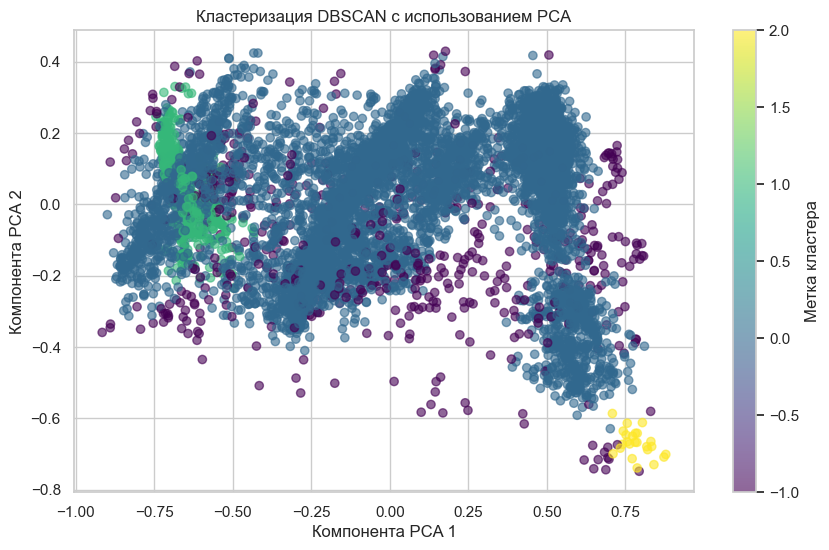

Коэффициент силуэта: -0.03641810927067965


In [56]:
# Уменьшение размерности с помощью PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(gt_df[['AT', 'AFDP', 'GTEP', 'TEY', 'CDP', 'CO']])

# Добавление результатов PCA в DataFrame
gt_df['PCA1'] = pca_result[:, 0]
gt_df['PCA2'] = pca_result[:, 1]

# Визуализация кластеров
plt.figure(figsize=(10, 6))
scatter = plt.scatter(gt_df['PCA1'], gt_df['PCA2'], c=gt_df['Best_Cluster'], cmap='viridis', marker='o', alpha=0.6)
plt.title('Кластеризация DBSCAN с использованием PCA')
plt.xlabel('Компонента PCA 1')
plt.ylabel('Компонента PCA 2')
plt.colorbar(scatter, label='Метка кластера')
plt.grid(True)
plt.show()

# Расчет коэффициента силуэта
score = silhouette_score(gt_df[['PCA1', 'PCA2']], gt_df['Best_Cluster'])
print(f'Коэффициент силуэта: {score}')

In [89]:
# Копируем исходный DataFrame и переименовываем
df_clust = gt_df.copy()

# Удаляем столбец 'Best_Cluster'
df_clust.drop(columns=['Best_Cluster'], inplace=True)

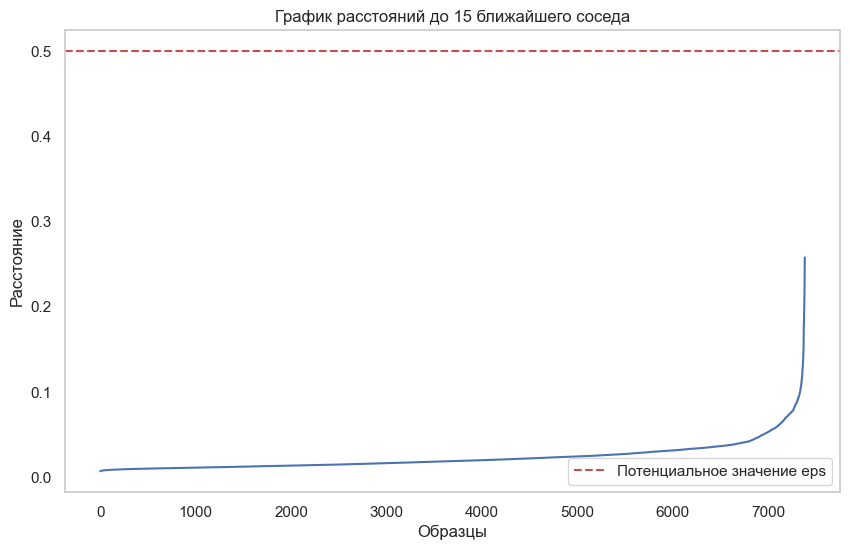

In [93]:
# Вычисляем расстояния до ближайших соседей
n_neighbors = 15  # Это соответствует min_samples в DBSCAN
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(df_clust[['PCA1', 'PCA2']])
distances, indices = neighbors_fit.kneighbors(df_clust[['PCA1', 'PCA2']])

# Сортируем расстояния до 4-го ближайшего соседа
distances = np.sort(distances[:, n_neighbors - 1], axis=0)  # n_neighbors - 1 из-за 0-индексации

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'График расстояний до {n_neighbors} ближайшего соседа')
plt.xlabel('Образцы')
plt.ylabel('Расстояние')
plt.grid()

# Визуализации порога eps
plt.axhline(y=0.5, color='r', linestyle='--', label='Потенциальное значение eps')
plt.legend()

plt.show()

Cluster
 0    6408
 1     544
-1     432
Name: count, dtype: int64


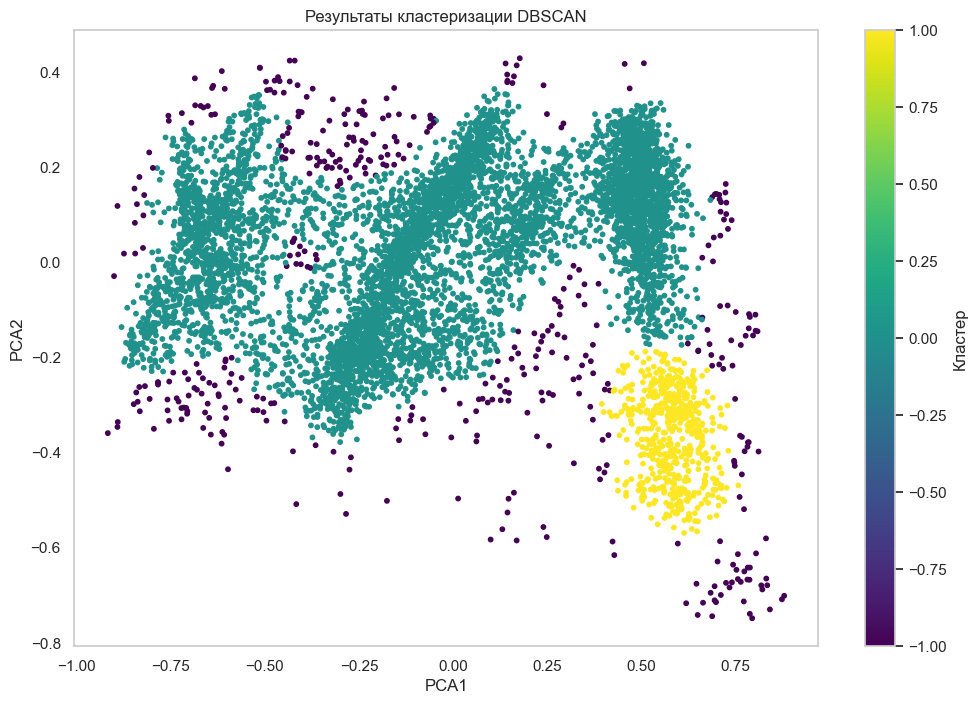

In [96]:
# Установка гиперпараметров
eps = 0.15  # Выбранное значение
min_samples = 25  # Подбор значения

# Стандартизация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clust[['PCA1', 'PCA2']])

# Обучение DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_clust['Cluster'] = dbscan.fit_predict(scaled_data)

# Проверка результатов
print(df_clust['Cluster'].value_counts())

# Визуализация результатов кластеризации
plt.figure(figsize=(12, 8))
plt.scatter(df_clust['PCA1'], df_clust['PCA2'], c=df_clust['Cluster'], cmap='viridis', s=10)
plt.title('Результаты кластеризации DBSCAN')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Кластер')
plt.grid()
plt.show()

# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных.

Результаты кластеризации DBSCAN показывают, что электростанции были разделены на три кластера: 0, 1 и -1. Кластер -1 представляет собой шумовые точки, которые не были отнесены ни к одному кластеру.

Кластер 0

Электростанции в кластере 0 имеют следующие характеристики:

    Высокие значения AT (около 0,17-0,18)
    Высокие значения AP (около 0,72-0,74)
    Средние значения AH (около 0,70-0,73)
    Средние значения AFDP (около 0,14-0,16)
    Средние значения GTEP (около 0,22-0,28)
    Средние значения TIT (около 0,57-0,67)
    Высокие значения TAT (около 0,93-0,95)

Электростанции в кластере 0, вероятно, являются высокоэффективными и имеют высокую производительность. Они имеют высокие значения AT и AP, что указывает на высокую температуру и давление пара. Кроме того, они имеют средние значения AH и AFDP, что указывает на среднюю эффективность и производительность.

Кластер 1

Электростанции в кластере 1 имеют следующие характеристики:

    Низкие значения AT (около 0,19)
    Высокие значения AP (около 0,68)
    Высокие значения AH (около 0,83)
    Низкие значения AFDP (около 0,06)
    Низкие значения GTEP (около 0,12)
    Низкие значения TIT (около 0,30)
    Средние значения TAT (около 0,59)

Электростанции в кластере 1, вероятно, являются менее эффективными и имеют более низкую производительность. Они имеют низкие значения AT и AFDP, что указывает на низкую температуру и давление пара. Кроме того, они имеют высокие значения AH, что указывает на высокую эффективность, но низкие значения GTEP и TIT, что указывает на низкую производительность.

Аномальные электростанции (кластер -1)

Аномальные электростанции в кластере -1 имеют следующие характеристики:

    Низкие значения AT (около 0,17-0,18)
    Высокие значения AP (около 0,68-0,72)
    Высокие значения AH (около 0,86-0,99)
    Низкие значения AFDP (около 0,01-0,09)
    Низкие значения GTEP (около 0,04-0,09)
    Низкие значения TIT (около 0,26-0,36)
    Высокие значения TAT (около 0,85-0,95)

Аномальные электростанции в кластере -1, вероятно, являются нестандартными и имеют необычную производительность. Они имеют низкие значения AT и AFDP, что указывает на низкую температуру и давление пара. Кроме того, они имеют высокие значения AH, что указывает на высокую эффективность, но низкие значения GTEP и TIT, что указывает на низкую производительность.

В целом, результаты кластеризации DBSCAN показывают, что электростанции можно разделить на три кластера: высокоэффективные, менее эффективные и аномальные. Аномальные электростанции имеют необычную производительность и могут потребовать дополнительного анализа и оптимизации.